In [1]:
import json
import random

import numpy as np
import scipy.signal
import astropy.io.fits
import matplotlib.pyplot as plt
from astropy.stats import LombScargle

import sonify

%matplotlib inline

![title](images/title.png)

# Start with some simple data

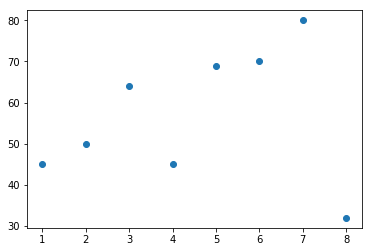

In [2]:
# Create some data we'd like to play from
simple_data = [(1, 45), (2, 50), (3, 64), (4, 45), (5, 69), (6, 70), (7, 80), (8, 32)]

# See what it looks like
plt.scatter(*zip(*simple_data))
                 

In [3]:
sonify.play_midi_from_data(simple_data)

Done playing!


# How to convert numbers to music?

## MIDI
###  Musical Instrument Digital Interface

>MIDI carries event messages that specify notation, pitch and velocity (loudness or softness), control signals for parameters such as volume, vibrato, audio panning from left to right, cues in theatre, and clock signals that set and synchronize tempo between multiple devices.

[source: wikipedia](https://en.wikipedia.org/wiki/MIDI)

![midi notes and values](images/midi_notes_values.png)

[source](http://computermusicresource.com/midikeys.html)

# Python has SO MANY great resources for this

[Python in music wiki](https://wiki.python.org/moin/PythonInMusic) 

For this talk, I'll be using [sonify](https://github.com/erinspace/sonify) (work in progress, some code that uses python to convert data to sound

The main components are:

- Midi creation using [midiutil](http://midiutil.readthedocs.io/en/stable/)
- Playing back that midi file using [pygame](https://www.pygame.org/docs/ref/mixer.html)


# Generate some more random data!

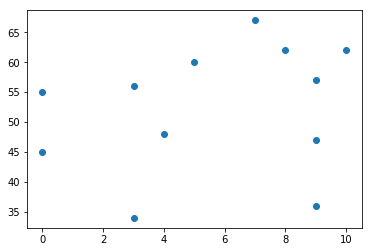

In [4]:
# Generate some random data

new_data = []
for i in range(0, 12):
    new_data.append((random.randint(0, 10), random.randint(30, 80)))
    
plt.scatter(*zip(*new_data))


In [5]:
sonify.play_midi_from_data(new_data)


Done playing!


In [6]:
sonify.play_midi_from_data(new_data, key='c_major')


Done playing!


In [7]:
sonify.play_midi_from_data(new_data, key='eb_major')


Done playing!


(more keys coming soon!)

![title](images/climate_data.png)


## "yearly average temperature anomalies"

[source](https://www.climate.gov/maps-data/dataset/global-temperature-anomalies-graphing-tool)

>Comparing the average temperature of land and ocean combined for a year period to the average temperature for the same period over the 20th century shows if conditions are warmer or cooler than the past.

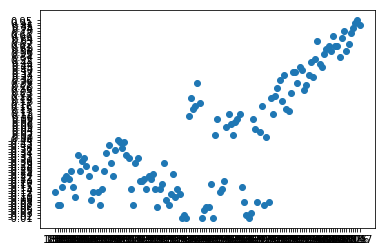

In [8]:
# Climate data from https://www.ncdc.noaa.gov/cag/

with open('sample_data/global_temp_anomolies_1880-2018.json') as data_file:    
    climate_json = json.load(data_file)

plt.scatter(climate_json['data'].keys(), climate_json['data'].values())

In [9]:
years = [int(year) for year in climate_json['data'].keys()]
temp_anomolies = [float(temp_anomaly) for temp_anomaly in climate_json['data'].values()]

normalized_years = sonify.scale_list_to_range(years, new_min=0, new_max=30)
normalized_temp_anomolies = sonify.scale_list_to_range(temp_anomolies, new_min=30, new_max=127)

normed_climate_data = list(zip(normalized_years, normalized_temp_anomolies))

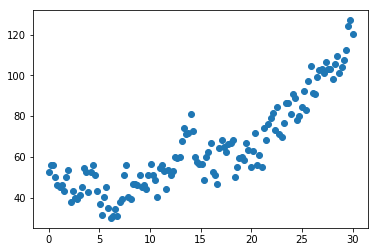

In [10]:
plt.scatter(*zip(*normed_climate_data))

In [11]:
sonify.play_midi_from_data(normed_climate_data)

Done playing!


# Exoplanet Data!

Let's look at some data from the Kepler Space Telescope.

This will all be a bit of a whirlwind, but it's the data we're after so hang on tight!

We'll be using data and code from Example from Geert Barentsen's [talk on "How to find a planet"](http://nbviewer.jupyter.org/github/barentsen/how-to-find-a-planet/blob/master/how-to-find-a-planet.ipynb)

This notebook goes into WAY more detail, so if you're interested definitely check it out1

![exoplanet transit](images/transit.gif)

# How Kepler gathers data

>Kepler gives us tiny images of stars at many different timestamps!

In [12]:
def get_kepler_data():
    """
    Example from @GeertHub's talk on "How to find a planet"
    http://nbviewer.jupyter.org/github/barentsen/how-to-find-a-planet/blob/master/how-to-find-a-planet.ipynb
    """
    # Read in Kepler data for star number 011904151
    data = astropy.io.fits.open("https://archive.stsci.edu/missions/kepler/target_pixel_files/0119/011904151/kplr011904151-2010009091648_lpd-targ.fits.gz")[1].data
    time = data["TIME"][data['QUALITY'] == 0]
    images = data["FLUX"][data['QUALITY'] == 0]
    
    lightcurve = np.sum(images, axis=(1, 2))
    trend = scipy.signal.savgol_filter(lightcurve, 101, polyorder=3) 
    percent_change = 100 * ((lightcurve / trend) - 1)

    frequency, power = LombScargle(time, percent_change, nterms=2).autopower(minimum_frequency=1/1.5, maximum_frequency=1/0.6, samples_per_peak=10)
    period = 1 / frequency[np.argmax(power)]

    return time, period, percent_change, images

/Users/erin/.virtualenvs/sonify/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


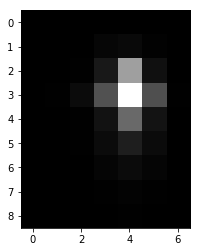

In [13]:
time, period, percent_change, images = get_kepler_data()

# Let's plot the image at the first timestamp
plt.imshow(images[0], cmap='gray', interpolation='nearest');

In [14]:
# In fact we have 9x7-pixel images at 926 different timestamps
images.shape

(926, 9, 7)

By measuring the brightness of each of those 926 images, a pattern emerges!

# Find the pattern in all that data

Though a bit of signal processing, you can tell that something seems to be happening in the brightness of the signal every 0.8 days!

Let's plot the data in 0.8-day chunks

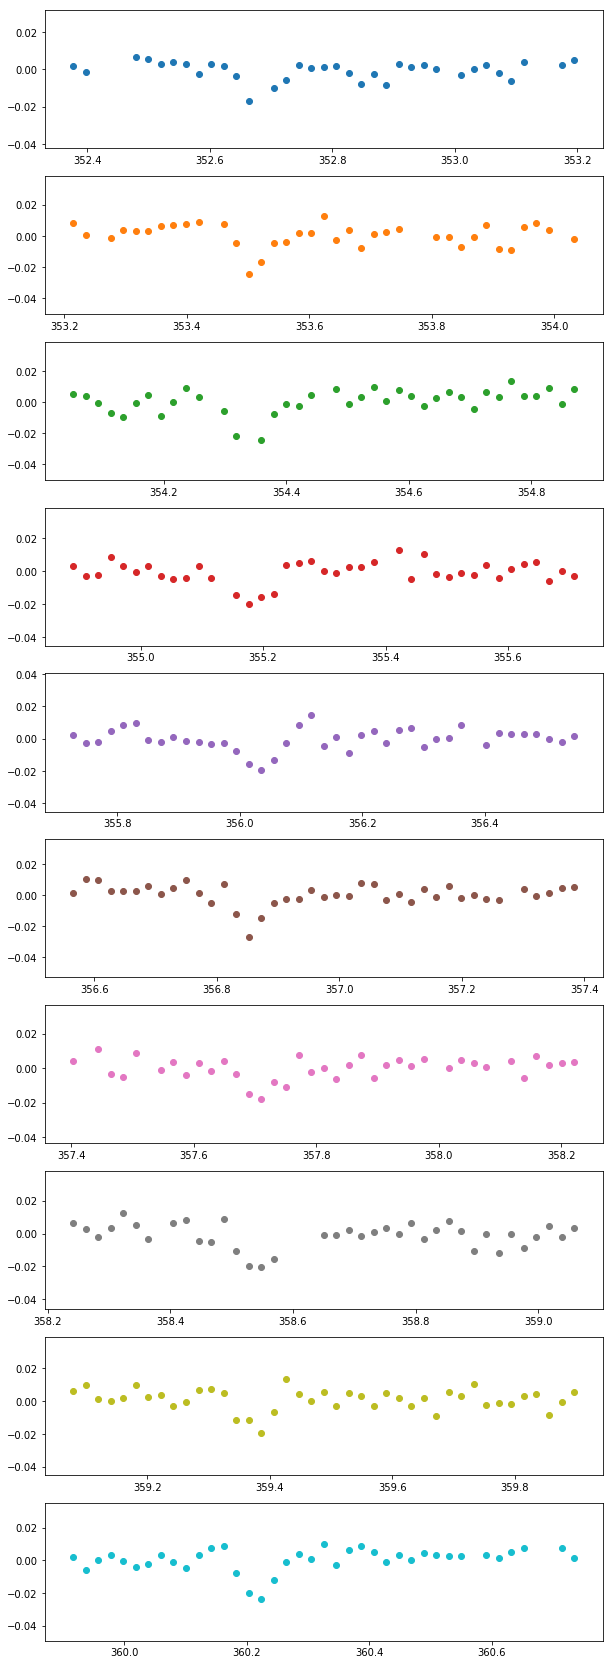

In [15]:
n_plots = 10
plt.figure(figsize=(10, 30))
for i in range(n_plots):
    mask = (time >= time[0] + i*period) & (time < time[0] + (i+1)*period)
    plt.subplot(n_plots, 1, i+1)
    plt.scatter(time[mask], percent_change[mask], c='C{}'.format(i))

# Process the Signal to use with Sonify!

In [16]:
def process_kepler_data(time, period, percent_change, low_note=20, high_note=100):    
    
    x_points = []
    y_points = []
    for i in range(10):
        mask = (time >= time[0] + i*period) & (time < time[0] + (i+1)*period)
        x_points += [x for x in time[mask] - time[0] - i*period]
        y_points += [y for y in percent_change[mask]]

    normalized_x = sonify.scale_list_to_range(x_points, new_min=0, new_max=30)
    normalized_y = sonify.scale_list_to_range(y_points, new_min=low_note, new_max=high_note)
    
    normed_data = list(zip(normalized_x, normalized_y))
    
    return normed_data

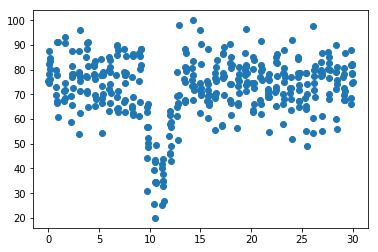

In [17]:
normed_data = process_kepler_data(time, period, percent_change)

plt.scatter(*zip(*normed_data))

In [18]:
sonify.play_midi_from_data(normed_data, key='c_major')


Done playing!


# Let's try playing each seperate lightcurve as a new track!

In [19]:
def process_kepler_data_multi_track(time, period, percent_change):
    
    points = []
    plt.figure(figsize=(10, 5))
    
    for i in range(10):
        mask = (time >= time[0] + i*period) & (time < time[0] + (i+1)*period)
        new_x = [x for x in time[mask] - time[0] - i*period]
        scaled_x = sonify.scale_list_to_range(new_x, new_min=0, new_max=30)
        
        new_y = [y for y in percent_change[mask]]
        scaled_y = sonify.scale_list_to_range(new_y, new_min=0, new_max=30)
                
        points.append(list(zip(scaled_x, scaled_y)))
        
        # Create the figure!
        mask = (time >= time[0] + i*period) & (time < time[0] + (i+1)*period)
        plt.scatter(time[mask] - time[0] - i*period, percent_change[mask])
            
    return points

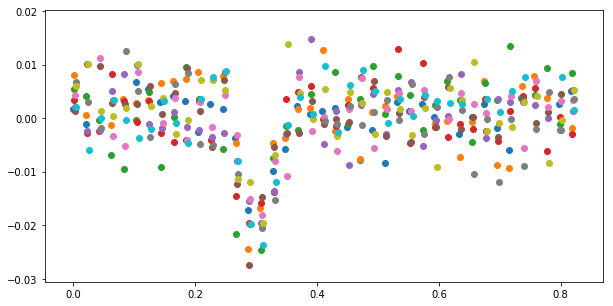

In [20]:
multitrack_data = process_kepler_data_multi_track(time, period, percent_change)

In [21]:
sonify.play_midi_from_data(multitrack_data, track_type='multiple', key='c_major')


Done playing!


# Where to go from here?

Python has so many great music making and data-interpreting resources!

A few neat python-related resources I found:

- [Make music from images](https://github.com/markkohdev/musicjawn)
- [Music from timeseries data](https://github.com/cirlabs/miditime)
- [Mido: Midi objects in python](https://mido.readthedocs.io/en/latest/)
- [C-sound python](https://github.com/csound/csoundAPI_examples/tree/master/python)
    - python wrapper for the csound API
    - a really powerful music making tool with a huge user community
    - More in general at http://csound.com/

# More sonification Information!

## Articles
- [Solar wind](https://www.npr.org/2013/02/10/171639280/want-to-create-a-space-symphony-wait-for-a-solar-storm)
- [Supernovae](https://www.npr.org/sections/thetwo-way/2014/01/10/261397236/dying-stars-write-their-own-swan-songs)


## Tools
- [Sonification at NASA](https://spdf.gsfc.nasa.gov/research/sonification/sonification.html)
- [Sonifier](http://www.sonify.net/)
- [NYU's Music Experience Design Lab](https://musedlab.org/)